# IMPORTING THE LIBRARIES

In [3]:
#!pip install einops

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat
import torch.nn as nn
import torch.nn.functional as F


#Importing models
from models import get_fcn_model
from models import get_unet_model
from models import get_resunet_model
from models import get_unet_attn_model
from models import get_resunet_model
from models import get_res_att_unet_model
from models import get_unet_aspp_model
from models import SwinTransformer

# PREPROCESSING DATA

- The two dictionaries defined below map the class labels used in the Cityscapes dataset to RGB color codes and to new category labels, respectively. This is commonly done in semantic segmentation tasks to visualize the segmentation results and to simplify the task by reducing the number of classes. 

- The id_map dictionary assigns each class label to a specific color, which is used to display the segmentation masks as an RGB image. The category_map dictionary groups the original class labels into new categories, which can be used to evaluate the performance of the segmentation algorithm in terms of more meaningful and general categories. 

- For example, in the category_map dictionary, all types of buildings are grouped into the same category, regardless of their specific label, making it easier to evaluate the accuracy of the segmentation algorithm for buildings as a whole.

In [9]:
warnings.filterwarnings("ignore")
plt.style.use("seaborn-darkgrid")
sns.set_context("paper", font_scale=1.4)

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

num_classes = len(id_map.keys())

**The code below performs image preprocessing and creates a dataset for a machine learning model that performs image segmentation. Image segmentation is the task of dividing an image into multiple segments or regions, each of which corresponds to a different object or part of the image.**

**1. The preprocess() function takes an image file path as input and performs the following operations on it:**

-Opens the image using the Image.open() method.

-Crops two regions of size (256, 256) from the input image, starting from the top-left corner of the image and the adjacent right region. The two cropped images are then resized to (128, 128).

-Normalizes the first cropped image to values between 0 and 1 and converts the second cropped image to a numpy array.

-Creates a black mask of the same size as the second cropped image to store the pixel-wise segmentation labels.

-Performs a color to class mapping on each pixel of the second cropped image by finding the class that the pixel's color is closest to using Euclidean distance. The corresponding class label is assigned to the corresponding pixel in the mask array.

-Reshapes the mask array to a three-dimensional array with a single channel.

**2.The prepare_tensor_dataset() function:**

-takes the file paths of the training and validation image directories as input and uses the preprocess() function to preprocess each image in these directories. The preprocessed images and masks are then stored in four separate lists, X_train, Y_train, X_val, and Y_val, which are returned by the function. These lists can be used to train and evaluate a machine learning model that performs image segmentation.


**We would be using the below code to preprocess our inference images:**

In [10]:
def preprocess(path):
    img = Image.open(path)
    

    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    
    # Normalize the image
    img1 = np.array(img1) / 255. 
    img2 = np.array(img2)
    

    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    

    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            
            a = img2[row, col, :]
            final_key = None
            final_d = None
            
            for key, value in id_map.items():
                
                d = np.sum(np.sqrt(pow(a - value, 2)))
                
                
                if final_key == None:
                    final_d = d
                    final_key = key
                
                elif d < final_d:
                    final_d = d
                    final_key = key
           
            mask[row, col] = final_key
    

    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    
    del img2
    return img1, mask



def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

# MODEL ARCHITECTURES:

In this demo, we will run several semantic segmentation models on the same set of inference images and compare their performance. The following models will be evaluated:

**1. FCN: Fully Convolutional Network**

**2. Unet: U-Net with skip connections**

**3. Unet+Attention: U-Net with attention mechanisms to focus on informative regions**

**4. Unet+Residual Network: U-Net with residual connections to improve gradient flow**

**5. RA-Unet: Revised Attention U-Net with attention and residual connections**

**6. Unet+ASPP: U-Net with Atrous Spatial Pyramid Pooling for multi-scale feature learning**

These models have been selected because they represent some of the most widely used and influential architectures in the field of semantic segmentation. They are all trained on the same dataset and will be evaluated on the same set of inference images to ensure a fair comparison.

#  FCN - BASELINE

1/1 [==============================] - 0s 22ms/step


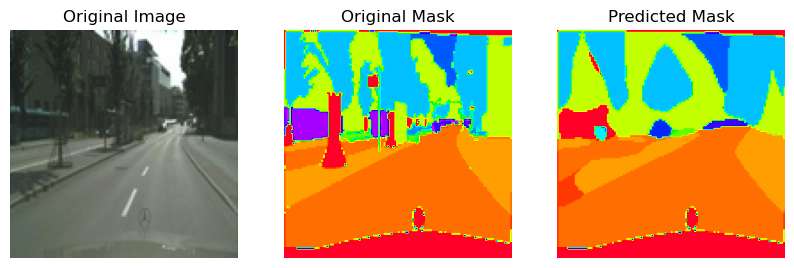

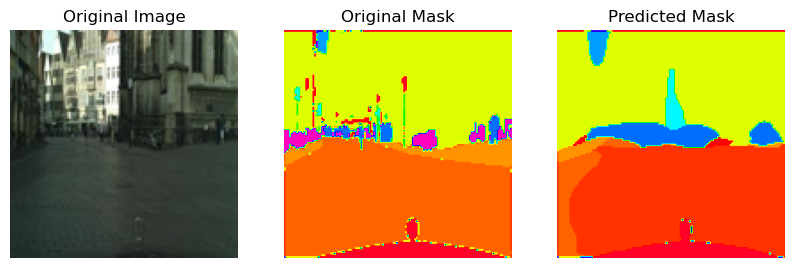

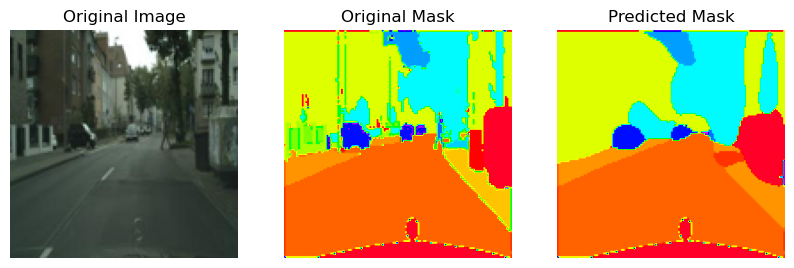

In [5]:

input_shape = (128, 128, 3)
batchnorm=True
model = get_fcn_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/fcn-bs16-esh5/fcn_bs16_es.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

#  UNET

1/1 [==============================] - 0s 22ms/step


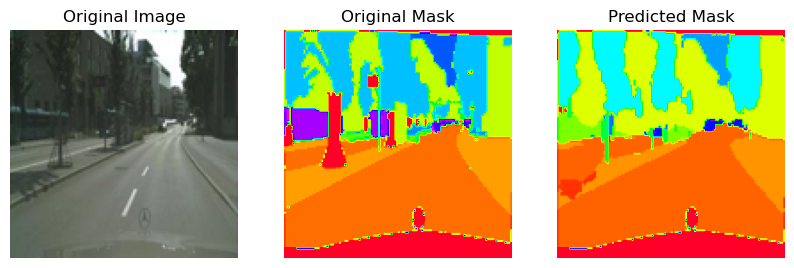

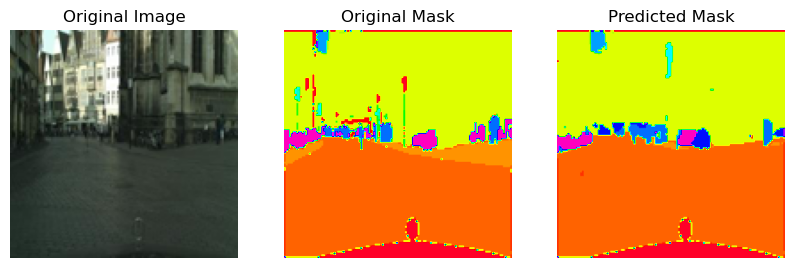

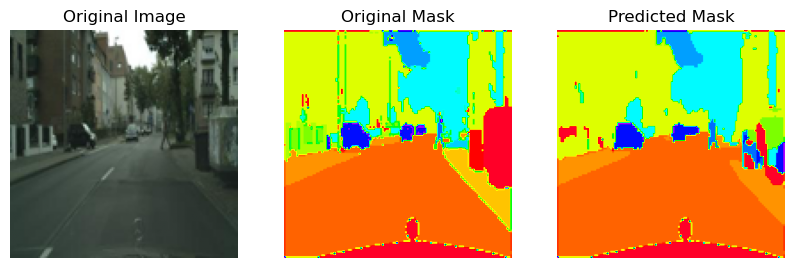

In [6]:
input_shape = (128, 128, 3)
batchnorm=True
model = get_unet_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/modelweights/unet_bs8_es.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

 # UNET + RESIDUAL NETWORK

1/1 [==============================] - 0s 24ms/step


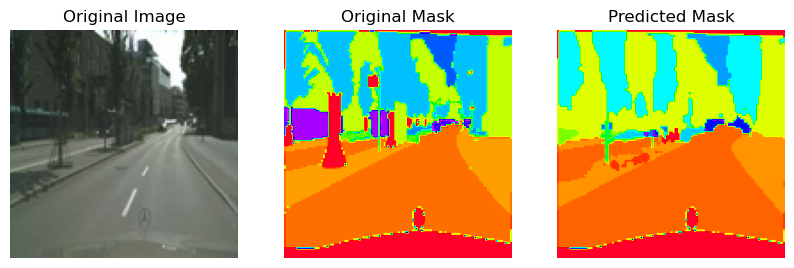

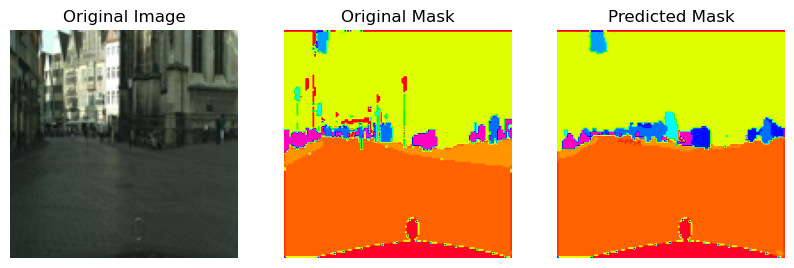

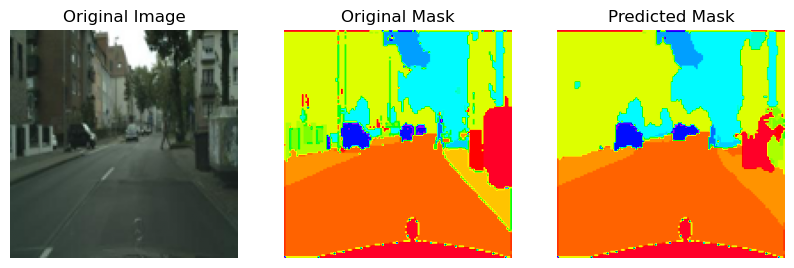

In [7]:
input_shape = (128, 128, 3)
batchnorm=True
model = get_resunet_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/modelweights/unet_res_bs16_es.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

# UNET + ATTENTION

1/1 [==============================] - 0s 28ms/step


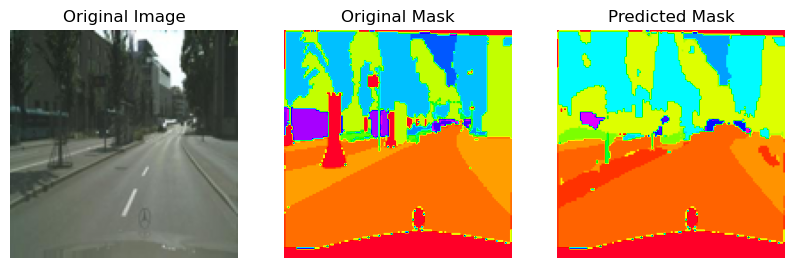

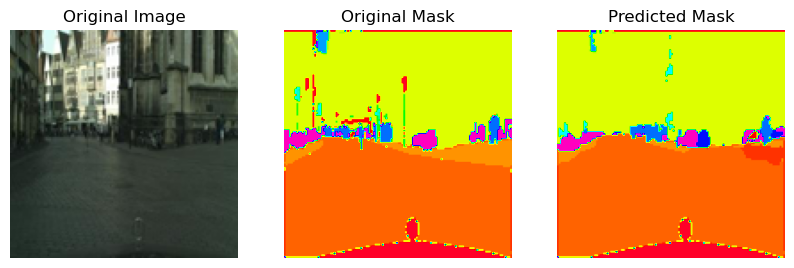

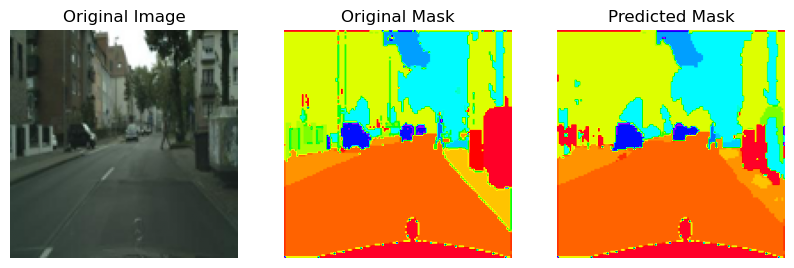

In [9]:
input_shape = (128, 128, 3)

model = get_unet_attn_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/modelweights/unet_attn_bs8_es.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

# UNET + RESIDUAL NETWORK + ATTENTION

1/1 [==============================] - 0s 23ms/step


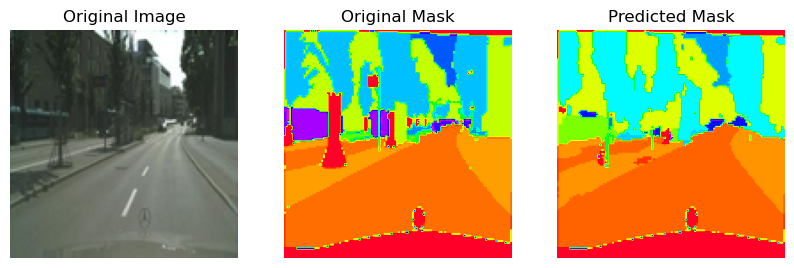

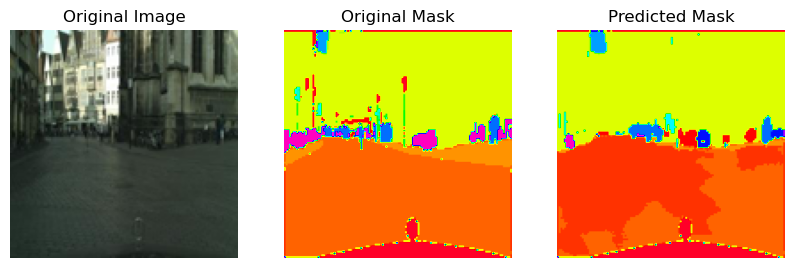

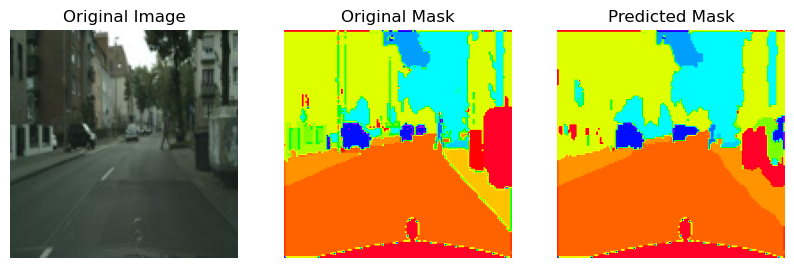

In [12]:
input_shape = (128, 128, 3)
batchnorm=True
model = get_res_att_unet_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/modelweights/unetresatt_bs8.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

# UNET + ASPP

1/1 [==============================] - 0s 23ms/step


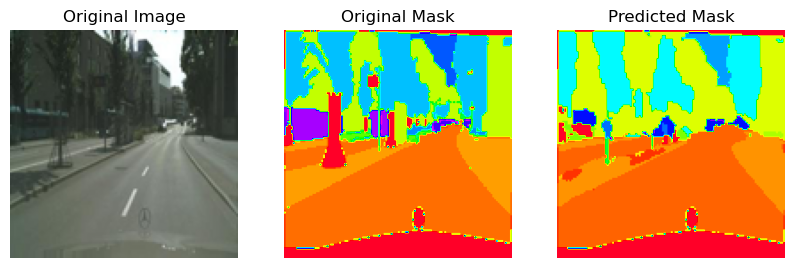

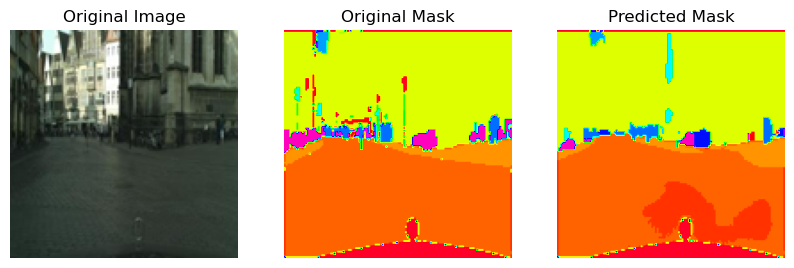

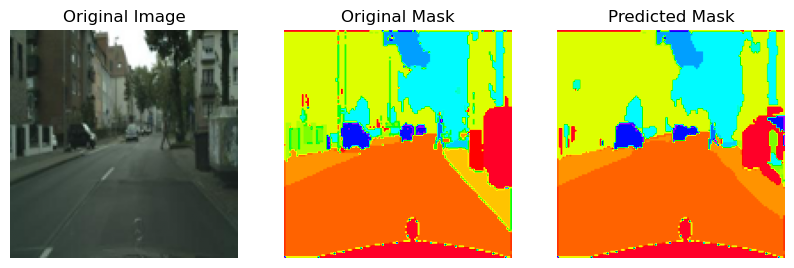

In [13]:
input_shape = (128, 128, 3)
batchnorm=True
model = get_unet_aspp_model()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])
# Loads the weights
model.load_weights("/kaggle/input/modelweights/unetaspp_bs4.h5")
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

# **Swin Tranformer based UNET model**

In [4]:
# Define Model
# assert torch.cuda.is_available()
device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=31,
    head_dim=32,
    window_size=4,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
loss_func = torch.nn.CrossEntropyLoss()
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(device)

1/1 [==============================] - 0s 23ms/step


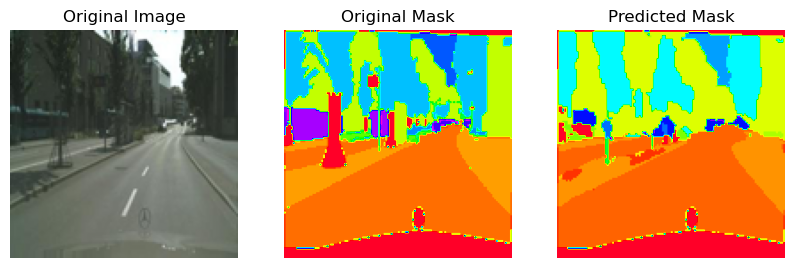

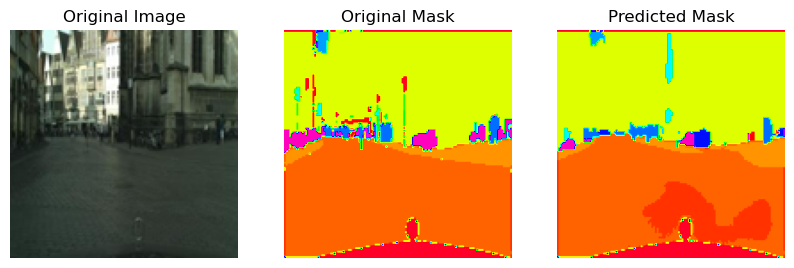

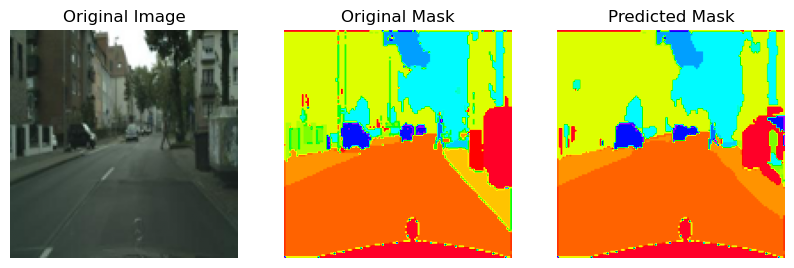

In [14]:
model.load_state_dict(torch.load("/kaggle/input/swin-wts/swin_transformer_b16_128"))
model.eval()
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model(torch.from_numpy(img).to(device).permute(0, 3, 1, 2).float())
    #print("Pred size:", pred.size())
    y_pred = torch.argmax(pred, axis=1)
    #print("y_pred size:", y_pred.size())
    y_pred=y_pred.cpu().detach().numpy()
    #print("y_pred shape:", y_pred.shape)
    #y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="gist_rainbow")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="gist_rainbow")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")